## Creating 128 x 128 Images and Labels

In this notebook we will smartly resize our data and save it.

For that we will stick to our paths and will write our data to:

In [50]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage
import tensorflow as tf
import create_labels
import cv2
import tqdm
tf.keras.backend.clear_session()


path_rgb_128 = "../datasets/train/AOI_11_Rotterdam/PS-RGB_128"
path_sar_128 = "../datasets/train/AOI_11_Rotterdam/SAR-Intensity_128"
path_labels_128 = "../datasets/train/AOI_11_Rotterdam/Labels_128"


for dir in [path_rgb_128,path_sar_128,path_labels_128]:
    if not os.path.exists(dir):
        os.makedirs(dir)


In [51]:
summary = create_labels.load_summary()
summary.head()

,ImageId,TileBuildingId,PolygonWKT_Pix,Mean_Building_Height,Median_Building_Height,StdDev_Building_Height
0,20190822070610_20190822070846_tile_3721,0,"POLYGON ((299.6396801332012 349.3765436094254,...",9.962397,9.96,0.006495
1,20190822070610_20190822070846_tile_3721,1,"POLYGON ((115.5360228798818 339.845588516444, ...",2.810000,2.81,0.000000
2,20190822070610_20190822070846_tile_3721,2,"POLYGON ((768.9086768317502 329.8960437048227,...",14.420000,14.42,0.000000
3,20190822070610_20190822070846_tile_3721,3,"POLYGON ((755.8174585120287 330.0953964963555,...",14.420000,14.42,0.000000
4,20190822070610_20190822070846_tile_3721,4,"POLYGON ((392.8786215754226 335.6222213506699,...",8.590000,8.59,0.000000


In [52]:
image_ids = [i[34:-4] for i in os.listdir("../datasets/train/AOI_11_Rotterdam/PS-RGB")]

even_ids = [i for i in image_ids if int(i[-1])%2==0]
odd_ids = [i for i in image_ids if int(i[-1])%2]

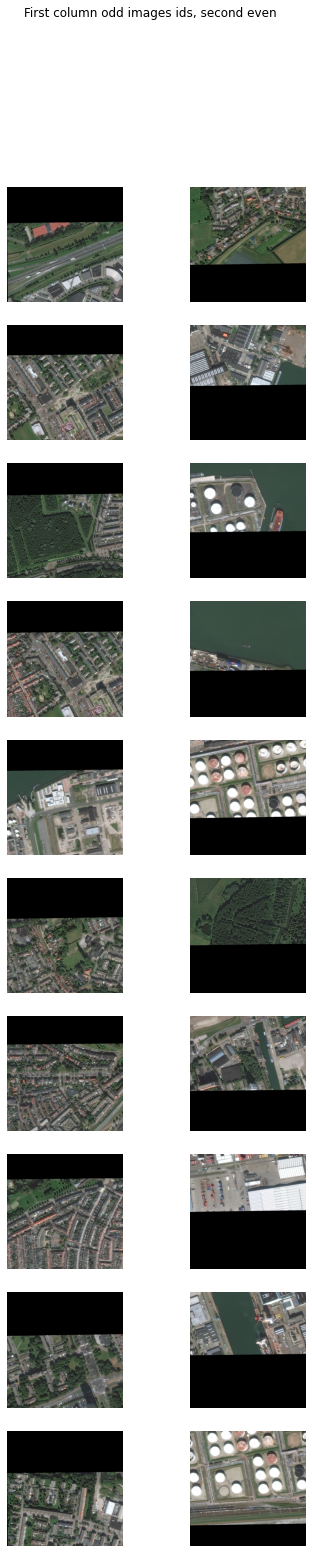

In [53]:
fig = plt.figure(figsize=(6, 25))
columns = 2
rows = 10

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)

    if i%2==0:
        path = f"../datasets/train/AOI_11_Rotterdam/PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_{even_ids[(i-1)//2]}.tif"
    else:
        path = f"../datasets/train/AOI_11_Rotterdam/PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_{odd_ids[i//2]}.tif"
    
    img = skimage.io.imread(path)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("First column odd images ids, second even") 
plt.show()

In [54]:
def find_end_of_black_bar(img):

    """ This functions finds the end of the black bar for an image, where there is a horizontal black bar on top"""

    i = 0

    while not img[i,:,:].sum():
        i+=1

    return i

def clever_resize(img,end_of_black_bar,target_shape=[128,128]):
    with_out_black = img[end_of_black_bar+1:]

    with_out_black = tf.image.convert_image_dtype(with_out_black, tf.float32)
    
    return tf.image.resize(with_out_black, target_shape)


def resize_images(img_id,target_shape):
    

    is_odd_id = int(img_id[-1])%2

    # reading paths:

    read_rgb_path = f"../datasets/train/AOI_11_Rotterdam/PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_{img_id}.tif"

    read_sar_path = f"../datasets/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_{img_id}.tif"



    rgb_img = cv2.imread(read_rgb_path,cv2.IMREAD_UNCHANGED) if is_odd_id else cv2.imread(read_rgb_path,cv2.IMREAD_UNCHANGED)[::-1,:,:]

    sar_img = cv2.imread(read_sar_path,cv2.IMREAD_UNCHANGED) if is_odd_id else cv2.imread(read_sar_path,cv2.IMREAD_UNCHANGED)[::-1,:,:]

    if sar_img.shape[-1]!=4:
        print("hier",sar_img.shape)

    mask_img = create_labels.mask_from_id(img_id, summary, edges=False)
    mask_img = np.expand_dims(mask_img,2) if is_odd_id else np.expand_dims(mask_img,2)[::-1,:,:]


    end_of_black_bar = find_end_of_black_bar(rgb_img)

    rgb_img, sar_img, mask_img = map(lambda img: clever_resize(img,end_of_black_bar,target_shape=target_shape),[rgb_img,sar_img,mask_img])

    mask_img = mask_img.numpy()

    mask_img[mask_img>0] = 1

    if not is_odd_id:
        rgb_img = rgb_img[::-1,:,:]
        sar_img = sar_img[::-1,:,:]
        mask_img = mask_img[::-1,:,:]


    return rgb_img.numpy(),sar_img.numpy(),mask_img.reshape(target_shape)

In [55]:
def write_resized(img_id,target_shape=[128,128]):
    
    rgb_img_res, sar_img_res, mask_img_res = resize_images(img_id,target_shape)

    # paths to write to

    write_rgb_path = f"../datasets/train/AOI_11_Rotterdam/PS-RGB_128/SN6_Train_AOI_11_Rotterdam_PS-RGB_{img_id}.tif"
    write_sar_path = f"../datasets/train/AOI_11_Rotterdam/SAR-Intensity_128/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_{img_id}.tif"
    write_label_path = f"../datasets/train/AOI_11_Rotterdam/Labels_128/{img_id}.tif"

    for img,path in zip([rgb_img_res, sar_img_res, mask_img_res],[write_rgb_path,write_sar_path,write_label_path]):


        cv2.imwrite(path,img)

In [56]:
for img_id in tqdm.tqdm(image_ids):

    write_resized(img_id)

100%|██████████| 3401/3401 [03:43<00:00, 15.22it/s]


In [57]:
all([cv2.imread(f"../datasets/train/AOI_11_Rotterdam/SAR-Intensity_128/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_{img_id}.tif",cv2.IMREAD_UNCHANGED).shape == (128,128,4) for img_id in image_ids])

True

In [59]:
model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

9420800/9406464 [==============================] - 1s 0us/step


In [61]:
model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________